# DVD Inversion exercise (GNSS- Low Noise)

This is the noteboook that solves the inversion exercise using just GNSS dataset

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Gnss
from vmod.source import Mctigue
from vmod.inverse import Inverse

## Read dataset

In [2]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xs,ys,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xs*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xs))]

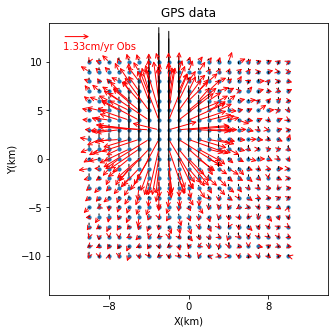

In [3]:
util.plot_gnss(xs,ys,uxs,uys,uzs)

## Create data object

In [4]:
obs=Gnss()

obs.add_names(names)

obs.add_xs(xs)
obs.add_ys(ys)

obs.add_ux(uxs)
obs.add_uy(uys)
obs.add_uz(uzs)

obs.add_errx(euxs)
obs.add_erry(euys)
obs.add_errz(euzs)

#obs.importcsv('examples/gps/fisher_gnss.txt')

## Create Model object

In [5]:
mct = Mctigue(obs)
uxsm,uysm,uzsm=mct.forward([0,0,2.0e3,5e2,1e6],unravel=False)

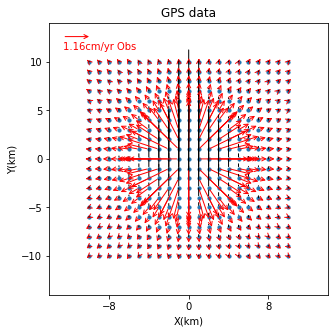

In [6]:
util.plot_gnss(xs,ys,uxsm,uysm,uzsm)

## Create Inversion object

In [ ]:
mct.set_x0([0,0,2.0e3,5e2,1e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-10000,-10000,5e2,1e1,1e5], high_bounds = [10000,10000,1e4,5e3,1e7])

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares Inversion

In [7]:
ans=inv.nlsq()

print(ans.x)

36.36328950168922
[-2.51704804e+03  2.87286709e+03  2.18446073e+03  1.01452030e+03
  1.27400018e+06]


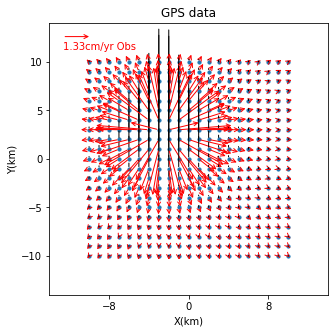

In [8]:
uxsm,uysm,uzsm=mct.forward(ans.x,unravel=False)

util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=1.33)

## Bayesian Inversion

In [9]:
trace,MDL=inv.mcmc('gnss_low')

 [-----------------100%-----------------] 1100000 of 1100000 complete in 1929.0 sec

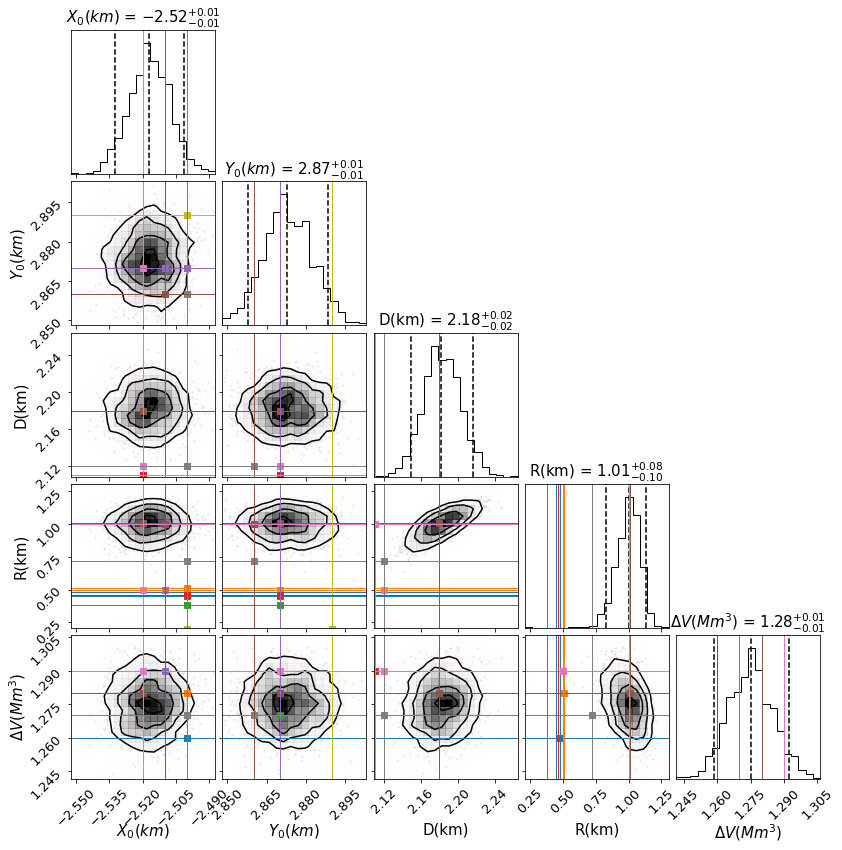

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$\Delta{V} (Mm^{3})$']

trus1=[-2.50,2.62,2.09,0.48,1.26]
trus2=[-2.50,2.59,2.09,0.51,1.28]
trus3=[-2.50,2.87,2.08,0,1.27]
trus4=[-2.52,2.87,2.11,0,1.29]
trus5=[-2.51,2.87,2.10,0.5,1.29]
trus6=[-2.52,2.87,2.18,1.01,1.28]
trus7=[-2.52,2.87,2.12,0.50,1.29]
trus8=[-2.50,2.86,2.12,0.72,1.27]
trus9=[-2.50,2.89,2.03,0.20,1.22]
trus10=[-2.50,2.87,2.02,0.11,1.23]
trus11=[-2.50,2.87,2.02,0.45,1.22]
trus12=[-2.50,2.87,2.02,0.50,1.21]
trus13=[-2.50,2.87,2.01,0.38,1.22]
trus14=[-2.50,2.87,2.02,0.46,1.22]
trus15=[-2.50,2.87,2.03,0.18,1.24]
trus16=[-2.51,2.86,2.37,1.00,0]
trus17=[-1.46,2.82,2.11,1.00,1.04]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

plt.rcParams.update({'font.size': 13})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,
                       show_titles=True, label_kwargs={"fontsize": 15}, title_kwargs={"fontsize": 15})

for i,tru in enumerate(trus):
    corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')

plt.savefig('histograms')

## Forward model for the median solution

[-2.51688354e+03  2.87288474e+03  2.18347053e+03  1.00366990e+03
  1.27406342e+06]


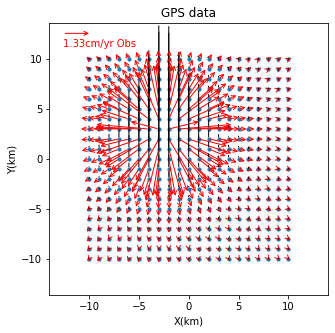

In [11]:
xbest=np.array([np.median(data[0,:]),np.median(data[1,:]),np.median(data[2,:]),np.median(data[3,:]),np.median(data[4,:])])
print(xbest)
uxsm,uysm,uzsm=mct.forward(xbest,unravel=False)
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=1.33)

In [12]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

meansP=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),50)
lower95P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),5)
upper95P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),95)
lower32P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),32)
upper68P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),68)
print(means)
print(lower95)
print(upper95)
print(lower32)
print(upper68)

print(meansP)
print(lower95P)
print(upper95P)
print(lower32P)
print(upper68P)

[-2516.883541291552, 2872.8847352041184, 2183.4705304362333, 1003.6698972943625, 1274063.4186864872]
[-2533.2200588824285, 2857.3388858457834, 2146.87396425914, 820.3029829580037, 1257431.7946816098]
[-2501.277239903846, 2888.458225837776, 2214.6687400141022, 1137.5129432207389, 1290813.1912783624]
[-2521.1960594521156, 2868.8530591480394, 2173.795102005633, 961.5655528289145, 1269020.6940358006]
[-2512.639588126862, 2877.6207875492846, 2192.8432257349245, 1047.1601731164408, 1279290.2998379758]
1604242.8445849987
1093904.462989228
2934926.3358709128
1410437.7243535635
1824325.3785413771
